In [123]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Internal modules
from pgaccess import get_flight_delays, execute_query
from plot_helpers import two_axes_plot

In [2]:
# Lets have a look at arrival delays
delays = get_flight_delays()
delays.shape

(15615741,)

Make a histogram for delays, and investigate if they seem to be from a normal distribution

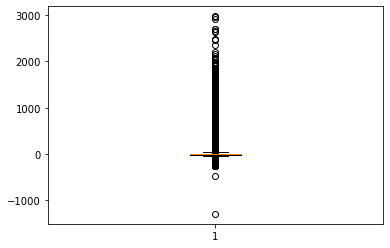

In [4]:
plt.boxplot(delays)
plt.show()

In [5]:
delays.mean()

5.475932330076428

There are two super obvious outliers in the negative direction.  
There are a bunch of sparse data points in the positive direction.  
I note, however, that 1440 minutes is 24 hours. If a flight is delayed by more than 24 hours I don't think that's something that can really be considered 'common' or 'predictable'

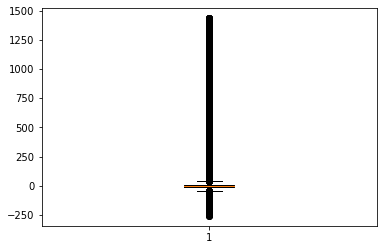

In [77]:
delaydrop = delays[(delays > -300) & (delays < 1440)]
plt.boxplot(delaydrop)
plt.show()

Realistically though, getting delayed by more than 8 hours seems extreme, as well as being more than 2 or 3 hours early. Those sound more like reschedules than delays.

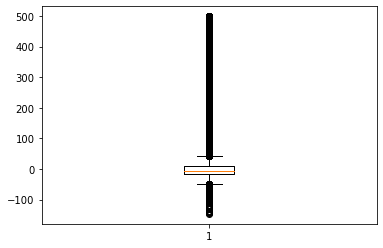

In [59]:
# I will use 150 and 500 because those numbers are nicer to look at
delaydrop = delaydrop[(delaydrop > -150) & (delaydrop < 500)]
plt.boxplot(delaydrop)
plt.show()

In [78]:
print(delaydrop.mean())
print(delaydrop.shape)

5.44621791583221
(15615451,)


As a final backup, we can remove values that match the IQR definition of an outlier

In [69]:
def remove_outliers(arr):
    firstQ = np.quantile(arr, 0.25)
    thirdQ = np.quantile(arr, 0.75)
    iqr = thirdQ - firstQ
    smallOutlier = firstQ - (iqr * 1.5)
    bigOutlier = thirdQ + (iqr * 1.5)
    return arr[(arr > smallOutlier) & (arr < bigOutlier)]
    
iqrdelays = remove_outliers(delays)
iqrdelays.shape

(14159860,)

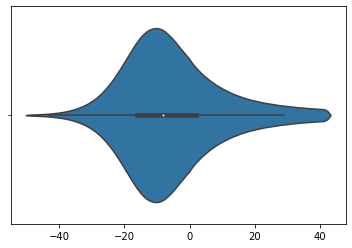

In [73]:
sns.violinplot(x=iqrdelays)
plt.show()

In [76]:
print(iqrdelays.min())
print(iqrdelays.mean())
print(iqrdelays.max())

-49.0
-5.453712536705871
42.0


That _looks_ a bit closer to normal, at the very least. Lets have a look at some test numbers.

In [47]:
from scipy.stats import normaltest
normaltest(delays)

NormaltestResult(statistic=22728920.77047994, pvalue=0.0)

In [74]:
normaltest(iqrdelays)

NormaltestResult(statistic=1041539.4756539622, pvalue=0.0)

In other words, there's no way in hell either of these are from a normal distribution

Trimming the delays list down to just the initial IQR x1.5 range restricts the available delay times to ±45 or so. The mean is slightly early, and times are late skewed.  
In the context of predicting flight delays. I'm not entirely sure how I feel about only having data for 45 minutes either way. I feel like a one hour, or even two/three hour delay isn't terribly uncommon. I would think those kinds of delays would probably be worth trying to allow for in the prediction model.

### Suggested metric 2
Investigate the mean/median delay on a month-by-month basis. Perhaps some months are more prone to delays than other months.  
This wasn't part of the suggestion, but my thought would also be is there a difference in the _count_ of delays. For that one I think I would just look for delays, disregarding any early arrivals.

In [80]:
delay_agg = execute_query("""
SELECT
    EXTRACT(MONTH FROM TO_DATE(fl_date, 'YYYY-MM-DD')) AS "month",
    AVG(arr_delay) AS average,
    PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY arr_delay) AS median,
    COUNT(*) FILTER(WHERE arr_delay > 0) AS count_delayed
FROM flights
GROUP BY "month"
""")
delay_agg

,month,average,median,count_delayed
0,1.0,3.958788,-7.0,409076
1,2.0,6.745096,-6.0,418572
2,3.0,2.818773,-7.0,441232
3,4.0,4.159131,-7.0,431428
4,5.0,6.511144,-6.0,477611
5,6.0,10.414444,-4.0,536216
6,7.0,8.977515,-5.0,518368
7,8.0,8.898890,-5.0,518692
8,9.0,1.708452,-8.0,376302
9,10.0,2.853585,-7.0,445570


I do notice that in every month, the median flight is early while the average flight is delayed. This suggests to me that there are a lot of flights which are just a bit early. But sometimes a flight is delayed and it gets very delayed.

Keeping in mind that this is including **all** times, not just the ones within the 45 minute windows. This does support the data from above where the delayed direction had a huge tail, which will draw the mean upwards. But when clipping that tail off the mean dropped into the early flights range.

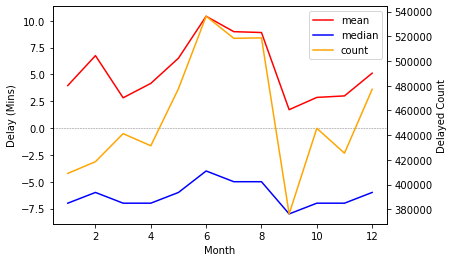

In [130]:
fig, ax = plt.subplots()
two_axes_plot(
    ax,
    delay_agg['month'],
    delay_agg[['average', 'median']].to_numpy(),
    delay_agg['count_delayed'],
    xlabel = 'Month',
    ylabel1 = 'Delay (Mins)',
    ylabel2 = 'Delayed Count',
    colors = [['red', 'blue'], 'orange'],
    legend = ['mean', 'median', 'count']
)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()

So it appears the summer months (June, July, August) have significantly more delayed flights, and the mean is also a fair bit higher. Though the median isn't really affected as much. That could be because there are more flights during those months, so the early flights help maintain the median's level. Though the increase in mean still suggests that the additional delays are worse, while the early flights are just more of the same.

In [92]:
delay_counts = execute_query("""
SELECT
    EXTRACT(MONTH FROM TO_DATE(fl_date, 'YYYY-MM-DD')) AS "month",
    COUNT(*) AS count_flights,
    COUNT(*) FILTER(WHERE arr_delay > 0) AS count_delayed
FROM flights
GROUP BY "month"
""")
delay_counts['ratio_delayed'] = delay_counts['count_delayed'] / delay_counts['count_flights']
delay_counts

,month,count_flights,count_delayed,ratio_delayed
0,1.0,1239868,409076,0.329935
1,2.0,1149857,418572,0.364021
2,3.0,1354995,441232,0.325634
3,4.0,1317246,431428,0.327523
4,5.0,1365999,477611,0.349642
5,6.0,1376471,536216,0.389559
6,7.0,1419558,518368,0.365162
7,8.0,1418808,518692,0.365583
8,9.0,1298326,376302,0.289836
9,10.0,1363034,445570,0.326896


The ratio looks to be in the low to mid 30% range across all months. September draws my eye as being the only month below 30% flights delayed.  
But those numbers do again support the idea that there aren't more flights than would be expected getting delayed, but the delays that do happen are much worse.

### Suggested metric 4
Look into taxi times during the day. Include here how the number of flights changes throughout the day as well.

We expect that increased traffic during the day would lead to more congested runways, and therefore more delays.

In [93]:
# Columns can be grouped by minute, that will give quite a bit of specificity
# I imagine there are enough rows to support that small of a bucket
# Start with just departures, that keeps the query simple
taxi_times = execute_query("""
SELECT
    dep_time,
    AVG(taxi_out) AS taxi_out,
    COUNT(*) AS flight_count
FROM flights
GROUP BY dep_time
""")
taxi_times

,dep_time,taxi_out,flight_count
0,1.0,16.853507,1769
1,2.0,16.665059,1453
2,3.0,16.648173,1478
3,4.0,16.368727,1380
4,5.0,16.679969,1279
...,...,...,...
1436,2357.0,17.318841,2072
1437,2358.0,17.049240,1911
1438,2359.0,16.935756,1900
1439,2400.0,16.723715,1306


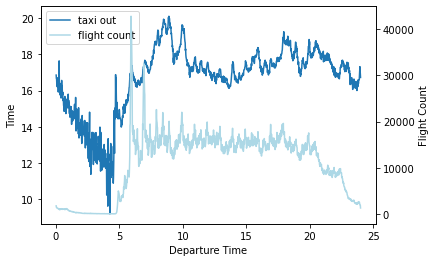

In [113]:
# It appears there are some rows where the time info is null
# Get those outta here
taxi_times = taxi_times.drop(index=[1440])

# Plot taxi time over time
fig, ax = plt.subplots()
# Convert departure time into decimal hours
two_axes_plot(
    ax,
    taxi_times['dep_time'].apply(lambda t: t // 100 + ((t % 100) / 60)),
    taxi_times['taxi_out'],
    taxi_times['flight_count'],
    xlabel = 'Departure Time',
    ylabel1 = 'Time',
    ylabel2 = 'Flight Count',
    colors = [None, 'lightblue'],
    legend = ['taxi out', 'flight count']
)
plt.show()

Taxi times do drop off into the night after flights have basically stopped. But both flights and taxi times remain mostly consistent throughtout the day.  
There's a small bump in taxi times around 9-10:00, but it doesn't appear to correspond to any increase in number of flights.

I do notice that there's a huge amount of flights leaving at 6am, then another spike at 7 or 7:30